# Diffusion Model for Multivariate Gaussian Mix

In [1]:
import torch 
import numpy as np
import tensorboard as tb 
import matplotlib.pyplot as plt
import scipy.stats as st
import random
from torch import optim, nn, utils, Tensor
import math
import plotly.express as px
import pandas as pd
import torch
import lightning as L

from pytorch_lightning.loggers import TensorBoardLogger
from typing import Callable
from mpl_toolkits.mplot3d import Axes3D


In [2]:
# Setting a seed and setting the device


seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)


if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print("CUDA available — deterministic settings applied.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available — seed set, but determinism not guaranteed.")
else:
    device = torch.device("cpu")
    print("CPU-only — seed set.")

print("Device = ", device)

def set_seed(seed_value=42):
    np.random.seed(seed_value)
    random.seed(seed_value)
    torch.manual_seed(seed_value)



device = torch.device("cpu")

MPS is available — seed set, but determinism not guaranteed.
Device =  mps


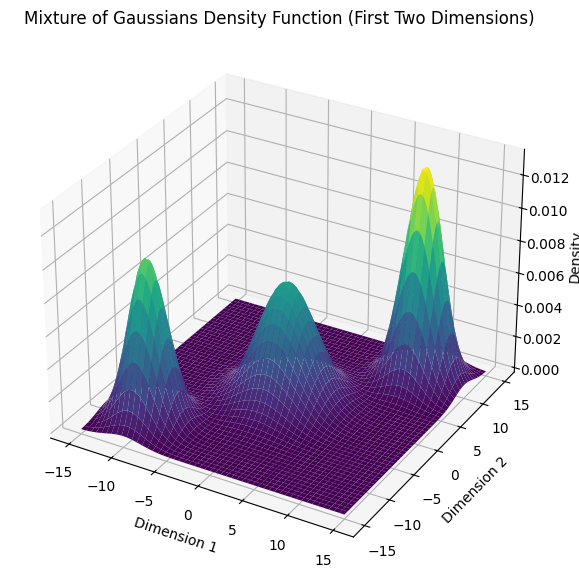

In [3]:
dim = 5



means = np.array([[-10]*dim, [0]*dim, [10]*dim])  
stds = np.array([2, 3, 2])  
weights = np.array([1/4, 5/12, 1/3])  
cov_matrices = np.array([np.diag([std ** 2] * dim) for std in stds])

x_min, x_max = -15, 15
y_min, y_max = -15, 15
x = np.linspace(x_min, x_max, 500)
y = np.linspace(y_min, y_max, 500)

X, Y = np.meshgrid(x, y)

means_2d = means[:, :2]  
covariances = np.array([np.diag([stds[i]**2, stds[i]**2]) for i in range(3)])  
weights_2d = weights 
pdfs = np.zeros((3, X.shape[0], X.shape[1]))  

for i in range(3):
    rv = st.multivariate_normal(mean=means_2d[i], cov=covariances[i])  
    pdfs[i] = rv.pdf(np.dstack((X, Y))) 

Z = np.sum(weights_2d[:, None, None] * pdfs, axis=0) 
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

ax.set_title("Mixture of Gaussians Density Function (First Two Dimensions)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Density")

plt.show()

In [4]:


def dataset_gen_multi(weights: np.ndarray, means: np.ndarray, stds: np.ndarray, device: torch.device = torch.device('cpu'), size: int = 1000) -> torch.Tensor:
    """
    We generate a Gaussian mixture using weights, means, and std. 
    The result is a sample from the Gaussian mixture in multiple dimensions.
    """
    
    dim = means.shape[1]  
    samples = np.zeros((size, dim))
    
    chosen_dists = np.random.choice(len(weights), size=size, p=weights)
    
    for i in range(len(weights)):
        component_mask = chosen_dists == i
        n_samples = np.sum(component_mask)
        
        mean = means[i, :]  
        std = stds[i]  
        covariance = np.diag([std**2] * dim)  
        
        samples[component_mask, :] = np.random.multivariate_normal(mean, covariance, n_samples)
    
    return torch.tensor(samples, dtype=torch.float32, device=device)



n = 100000
x_0 = dataset_gen_multi(weights=weights, means=means, stds=stds, device=device, size=n)

print(x_0.shape) 

torch.Size([100000, 5])


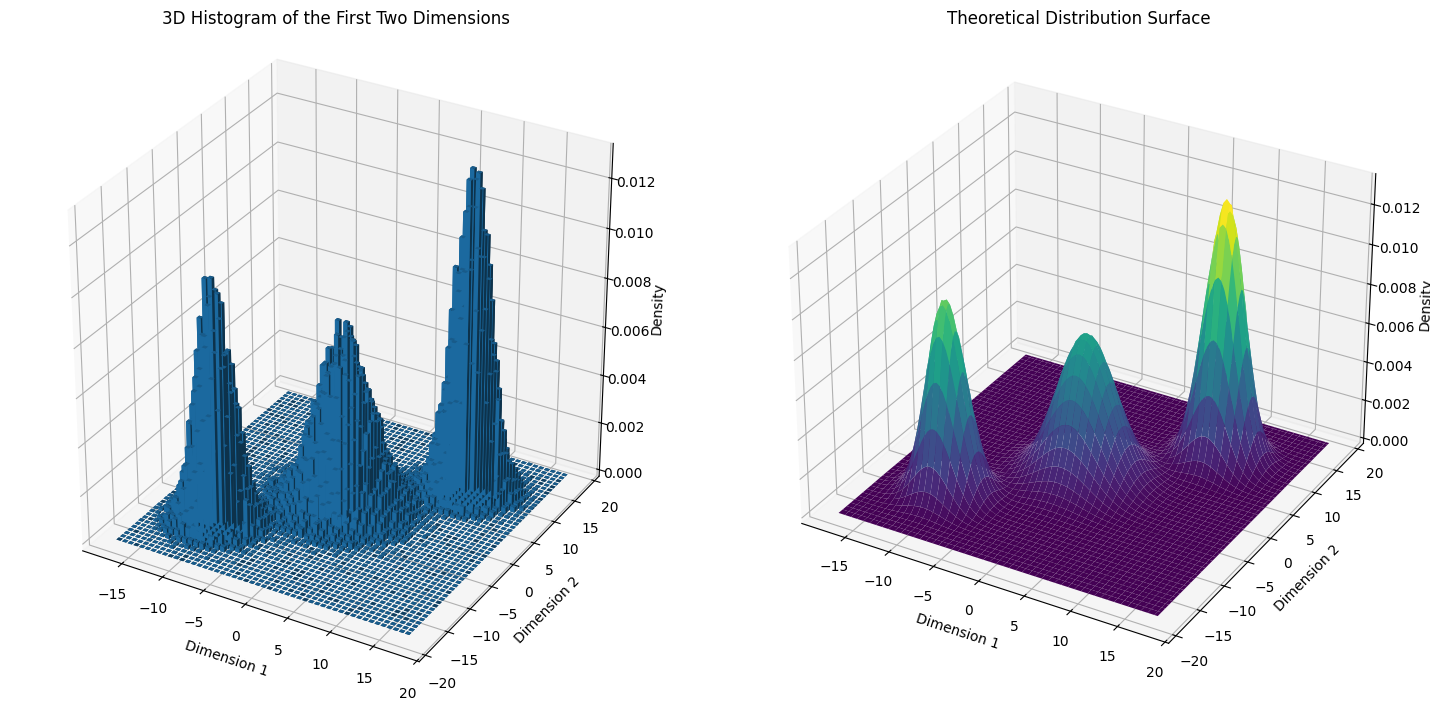

In [5]:
x_data = x_0[:, 0].cpu().numpy()  # First dimension
y_data = x_0[:, 1].cpu().numpy()  # Second dimension

fig, ax = plt.subplots(1, 2, figsize=(15, 7), subplot_kw={'projection': '3d'})

ax[0].set_box_aspect([1, 1, 1])  # Equal aspect ratio
hist, xedges, yedges = np.histogram2d(x_data, y_data, bins=50, density=True)

xpos, ypos = np.meshgrid(xedges[:-1] + 0.1, yedges[:-1] + 0.1, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)

dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax[0].bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')
ax[0].set_zlabel('Density')
ax[0].set_title('3D Histogram of the First Two Dimensions')

x_vals = np.linspace(np.min(x_data), np.max(x_data), 100)
y_vals = np.linspace(np.min(y_data), np.max(y_data), 100)
X, Y = np.meshgrid(x_vals, y_vals)

Z = np.zeros_like(X)
for i in range(3):  # 3 components
    mean_x, mean_y = means[i, 0], means[i, 1]  # Mean for each component
    std = stds[i]
    weight = weights[i]
    Z += weight * (1 / (2 * np.pi * std**2)) * np.exp(-0.5 * ((X - mean_x)**2 + (Y - mean_y)**2) / std**2)

ax[1].plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')
ax[1].set_zlabel('Density')
ax[1].set_title('Theoretical Distribution Surface')

plt.tight_layout()
plt.show()

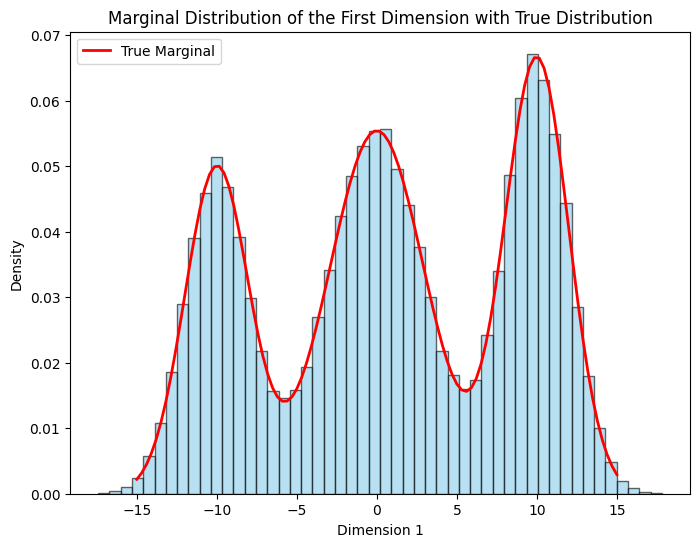

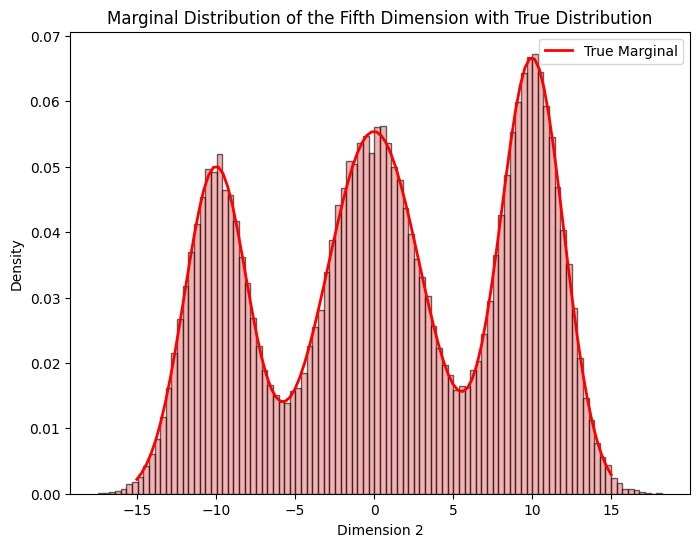

In [6]:
plt.figure(figsize=(8, 6))

plt.hist(x_0[:, 0].cpu(), bins=50, color='skyblue', edgecolor='black', density=True, alpha=0.6)

x_vals = np.linspace(x_min, x_max, 100) 
true_marginal_1 = np.zeros_like(x_vals)

for i in range(3): 
    mean = means[i, 0]  
    std = stds[i]
    weight = weights[i]
    true_marginal_1 += weight * (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_vals - mean) / std)**2)

plt.plot(x_vals, true_marginal_1, color='r', label='True Marginal', linewidth=2)

plt.title('Marginal Distribution of the First Dimension with True Distribution')
plt.xlabel('Dimension 1')
plt.ylabel('Density')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))

plt.hist(x_0[:, 4].cpu(), bins=100, color='lightcoral', edgecolor='black', density=True, alpha=0.6)
#
y_vals = np.linspace(y_min, y_max, 100)  
true_marginal_2 = np.zeros_like(y_vals)

for i in range(3):  
    mean = means[i, 4] 
    std = stds[i]
    weight = weights[i]
    true_marginal_2 += weight * (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((y_vals - mean) / std)**2)

plt.plot(y_vals, true_marginal_2, color='r', label='True Marginal', linewidth=2)

plt.title('Marginal Distribution of the Fifth Dimension with True Distribution')
plt.xlabel('Dimension 2')
plt.ylabel('Density')
plt.legend()
plt.show()

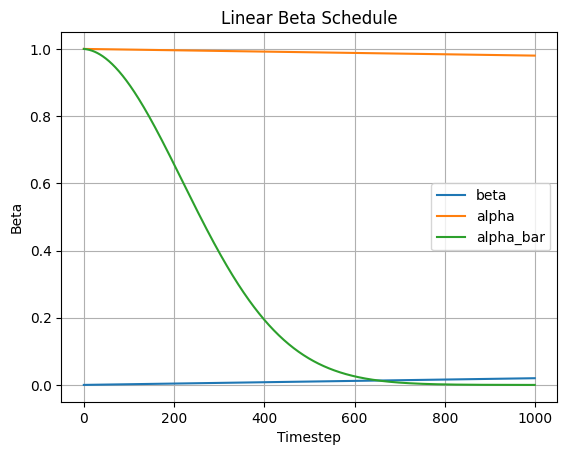

In [7]:

def linear_beta_scheduler(timesteps: int, start: float = 1e-4, end: float = 0.02):
    return torch.linspace(start, end, timesteps, device = device)

timesteps = 1000
start = 0.0001
end = 0.02
beta =  linear_beta_scheduler(timesteps,start = start, end = end)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)

plt.plot(beta.cpu().numpy(), label = "beta")
plt.plot(alpha.cpu().numpy(), label = "alpha")
plt.plot(alpha_bar.cpu().numpy(), label = "alpha_bar")
plt.title("Linear Beta Schedule")
plt.xlabel("Timestep")
plt.ylabel("Beta")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
def noising(t_index : torch.Tensor, x_0: torch.Tensor, alpha_bar: torch.Tensor, seed : int = None, noise : torch.tensor = None) -> torch.Tensor:
    """ 
    This function defines the noising process from a batch tensor of x_0
    x_0 is supposed to be of size batch_size x x_size
    t is supposed to be of size batch_size
    Attention to t_index, tensor are indexed with a shift of -1 in comparaison to timesteps. 
    If we pass the indexes we should just perform alpha_bar[t_index], if we pass time steps we should do alpha_bar[t_index -1]
    """
    
    if noise is None:
        noise = torch.randn_like(x_0, device=x_0.device)

    alpha_bar_t = alpha_bar[t_index].view(-1, *[1] * (x_0.dim() - 1))
        

    return torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise    



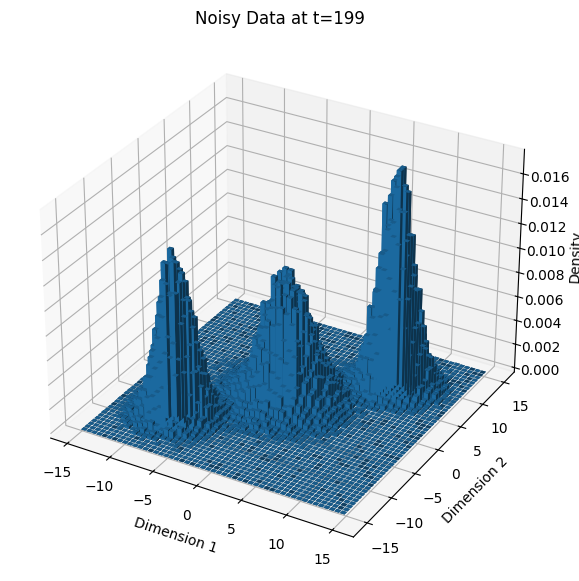

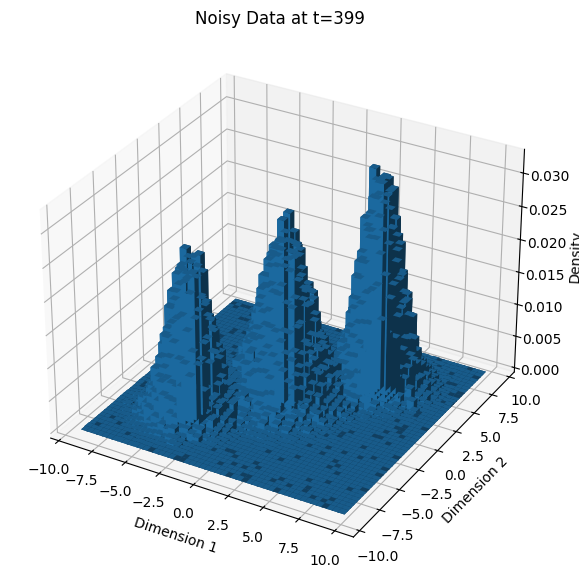

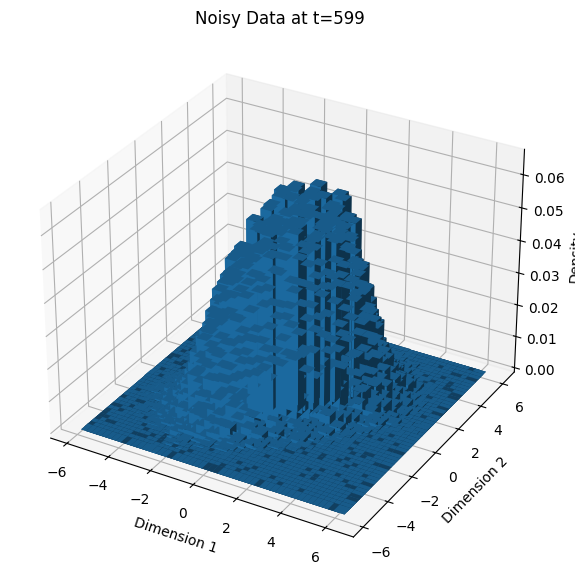

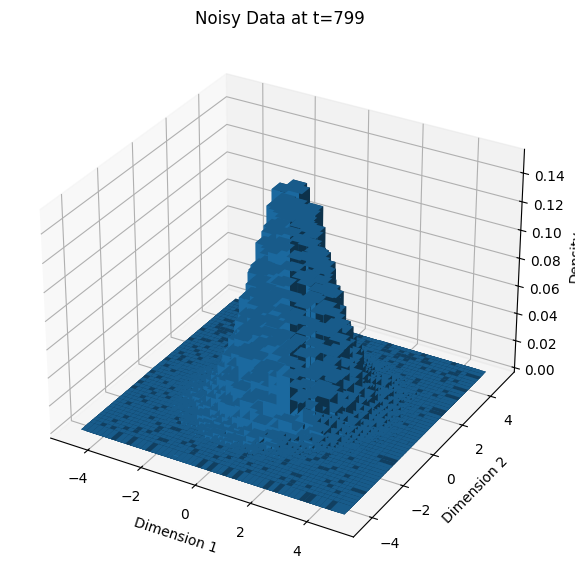

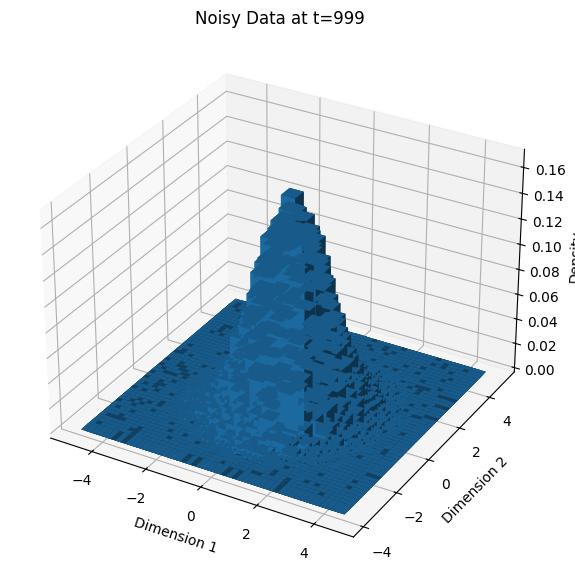

Means of noised data :  [0.00114882 0.00883379 0.01016239 0.00429902 0.005483  ]
Covariances Matrix of noised data:  [[ 1.01295163e+00 -9.36575836e-04  3.31847671e-04 -5.47959649e-04
   4.30755349e-03]
 [-9.36575836e-04  1.01274239e+00 -2.58612895e-03 -2.45970047e-03
   2.75032421e-03]
 [ 3.31847671e-04 -2.58612895e-03  1.00268999e+00  3.81759784e-03
  -5.65319583e-04]
 [-5.47959649e-04 -2.45970047e-03  3.81759784e-03  9.95958541e-01
   3.23892678e-03]
 [ 4.30755349e-03  2.75032421e-03 -5.65319583e-04  3.23892678e-03
   1.00279795e+00]]


In [9]:

def plot_3d_histogram(x_data, y_data, title):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Create a 2D histogram
    hist, xedges, yedges = np.histogram2d(x_data, y_data, bins=50, density=True)

    xpos, ypos = np.meshgrid(xedges[:-1] + 0.1, yedges[:-1] + 0.1, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = np.zeros_like(xpos)

    dx = dy = 0.5 * np.ones_like(zpos)
    dz = hist.ravel()

    # Create 3D bars
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Density')
    ax.set_title(title)

    plt.show()



for t in range(timesteps): 
    t_index = torch.full((x_0.shape[0],), t, device=device)  

    noisy_data = noising(t_index, x_0, alpha_bar)  

    x_data = noisy_data[:, 0].cpu().numpy()
    y_data = noisy_data[:, 1].cpu().numpy()

    if (t+1) % 200 == 0:  
        plot_3d_histogram(x_data, y_data, f'Noisy Data at t={t}')
        
noisy_data_numpy = noisy_data.cpu().numpy()


cov_matrix = np.cov(noisy_data_numpy, rowvar=False)  
# Mostra la matrice di covarianza
print("Means of noised data : ", np.mean(noisy_data_numpy, axis=0))
print("Covariances Matrix of noised data: ", cov_matrix)

In [10]:
def generate_with_noiser_multi(size: int = 100, dim : int = None, seed: int = None, x_t: torch.Tensor = None, 
                        noiser: Callable = None, beta: torch.Tensor = None, alpha_bar : torch.Tensor = None,
                        timesteps : int = None,
                        alpha : torch.Tensor = None, normalized : bool = False, mean: torch.Tensor = None, std: torch.Tensor = None ) -> list:  
    
    
    """
    Generation of the sample using the instructions for the noiser given by arXiv:2006.11239v2
    """
    
    if seed is not None:
        torch.manual_seed(seed)
    
    alpha_bar_minus = nn.functional.pad(
            alpha_bar[:-1], (1, 0), value=1.0)
    sigma = torch.sqrt(beta * (1.0 - alpha_bar_minus) / (1.0 - alpha_bar))


    if x_t is None: 
        x_t = torch.randn(size, dim, device=device)



    if isinstance(noiser, nn.Module):
        noiser.eval()
    

    with torch.no_grad():
        for t in reversed(range(timesteps)): 
            t_index = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)

            noise = noiser(x_t, t_index)
            
            z = torch.randn_like(x_t) if t > 0 else 0.0

            coef = (1 - alpha[t]) / torch.sqrt(1 - alpha_bar[t])
            
            x_t = (
                (1 / torch.sqrt(alpha[t]))
                * (x_t - coef * noise)
                + sigma[t] * z
            )
    
    if normalized:
        
        return x_t * std.unsqueeze(0) + mean.unsqueeze(0)
    else:
        return x_t
    
    
def generation_through_real_score(size: int = 100, seed: int = None, x_t: torch.Tensor = None, score: Callable = None,
                                beta: torch.Tensor = None, timesteps: int = 1000, normalized: bool = False, 
                                mean: torch.Tensor = None, cov_matrix: torch.Tensor = None) -> torch.Tensor:  
    
    if isinstance(score, nn.Module):
        score.eval()
        
    if seed is not None:
        torch.manual_seed(seed)
    
    
    with torch.no_grad():
        for t in reversed(range(timesteps)):
            
            score_t = score(x_t, t)
            
            
            z = torch.randn_like(x_t)
            x_t = (1 / torch.sqrt(1 - beta[t])) * (x_t + beta[t] * score_t) + torch.sqrt(beta[t]) * z
    
    
    if normalized:

        return mean.unsqueeze(0) + noise *std.unsqueeze(0)
    else:   
        return x_t


In [11]:
def normal_logpdf_multivariate(x: torch.Tensor, mean: torch.Tensor, cov_matrix: torch.Tensor) -> torch.Tensor:
    """
    Computes the log-density (or density) of a multivariate normal distribution.
    - x: (N, D)
    - mean: (D,)
    - cov_matrix: (D, D)
    Returns:
        - (N,) tensor of log-density values (or density if return_log=False)
    """
    x = torch.atleast_2d(x)  # (N, D)
    mean = mean.unsqueeze(0)  # (1, D)
    d = x.shape[1]

    cov_inv = torch.linalg.inv(cov_matrix)  # (D, D)
    cov_det = torch.det(cov_matrix.cpu()).clamp(min=1e-6)  # Prevent log(0)

    diff = x - mean  # (N, D)
    mahalanobis = torch.sum((diff @ cov_inv) * diff, dim=1)  # (N,)
    
    log_coeff = -0.5 * (d * torch.log(torch.tensor(2 * torch.pi)) + torch.log(cov_det))
    log_exponent = -0.5 * mahalanobis
    log_pdf = log_coeff + log_exponent  # (N,)

    
    return log_pdf  # Stable log-density


In [12]:
def density_mix_gaussian(x: torch.Tensor, means: torch.Tensor, cov_matrix: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
    """
    Vectorized computation of the density of a Gaussian mixture (multivariate).
    Input tensor x is of shape N x D (N data points, D components)
    Input tensor means is of shape M x D (M means for each component)
    Input tensor cov_matrix is of shape M x D x D (M covariance matrices for each component)
    Input tensor weights is of shape M (weights for each component)
    Output tensor is of shape N (N data points, probability density)
    """
    x = torch.atleast_2d(x)  # N x D
    M, D = means.shape
    N = x.shape[0]

    log_weights = torch.log(weights / weights.sum())  # M

    log_probs = []
    for i in range(M):
        log_pdf = normal_logpdf_multivariate(x, means[i], cov_matrix[i])  # (N,)
        log_probs.append(log_weights[i] + log_pdf)  # log(weight * p(x|mean_i, cov_i))

    log_probs = torch.stack(log_probs, dim=1)  # (N, M)
    log_mix = torch.logsumexp(log_probs, dim=1)  # (N,)

    return torch.exp(log_mix)  # N


def score_mix_gaussian(x: torch.Tensor, means: torch.Tensor, cov_matrix: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
    
    """
    Compute the score (gradient of log-density) for a Gaussian mixture model (multivariate).
    
    Input tensor x is of shape N x D (N data points, D components)
    Input tensor means is of shape M x D (M means for each component)
    Input tensor cov_matrix is of shape M x D x D (M covariance matrices for each component)
    Input tensor weights is of shape M (weights for each component)
    
    Output tensor is of shape N x D (N data points, D components for the score)
    """
    
    x = torch.atleast_2d(x)  
    M, D = means.shape
    N = x.shape[0]

    log_weights = torch.log(weights / weights.sum())  # M
    log_probs = torch.zeros((N, M), device=x.device)
    gradients = torch.zeros((N, M, D), device=x.device)

    for i in range(M):
        mean_i = means[i]  # D
        cov_i = cov_matrix[i]  # D x D
        cov_inv = torch.linalg.inv(cov_i)  # D x D

        # log p(x | mean_i, cov_i)
        log_pdf = normal_logpdf_multivariate(x, mean_i, cov_i)  # N
        log_probs[:, i] = log_weights[i] + log_pdf  # N

        diff =  mean_i.unsqueeze(0) - x   # N x D
        gradients[:, i, :] = diff @ cov_inv  # N x D

    log_mixture = torch.logsumexp(log_probs, dim=1, keepdim=True)  # N x 1
    responsibilities = torch.exp(log_probs - log_mixture)  # N x M

    score = torch.sum(responsibilities.unsqueeze(2) * gradients, dim=1)  # N x D

    return score

In [13]:
def score_mix_gaussian_factory(alpha_bar: torch.Tensor, means: torch.Tensor, cov_matrices: torch.Tensor, weights: torch.Tensor, device  = device):
    """
    Factory function to create the score function with fixed means, covariance matrices, and weights.
    Returns a score function that can be used to calculate the score at time t.
    """
    
    def score(x_t: torch.Tensor, t: int) -> torch.Tensor:
        """
        Computes the score of the mixture of Gaussians at time t.
        """
        x_t = torch.atleast_2d(x_t)  # Ensure x_t is N x D
        
        
        alpha_t = alpha_bar[t]
        
        
        means_t = means * torch.sqrt(alpha_t)  # shape M x D
        
        cov_t = (1 - alpha_t) * torch.eye(x_t.shape[1], device=x_t.device).unsqueeze(0) + cov_matrices * alpha_t  # shape M x D x D
        
        return score_mix_gaussian(x_t, means_t, cov_t, weights)  # shape N
    
    return score

In [14]:
weights_tensor = torch.tensor(weights, dtype=torch.float32, device=device)




means_tensor = torch.tensor(means, dtype=torch.float32, device=device)
cov_matrices_tensor = torch.tensor(cov_matrices, dtype=torch.float32, device=device)

size = 10000

score_function = score_mix_gaussian_factory(alpha_bar, means_tensor, cov_matrices_tensor, weights_tensor)

generated_samples = generation_through_real_score(x_t = torch.randn(size, dim, device = device),
    size=size,
    score=score_function,
    beta=beta,
    timesteps=timesteps
)




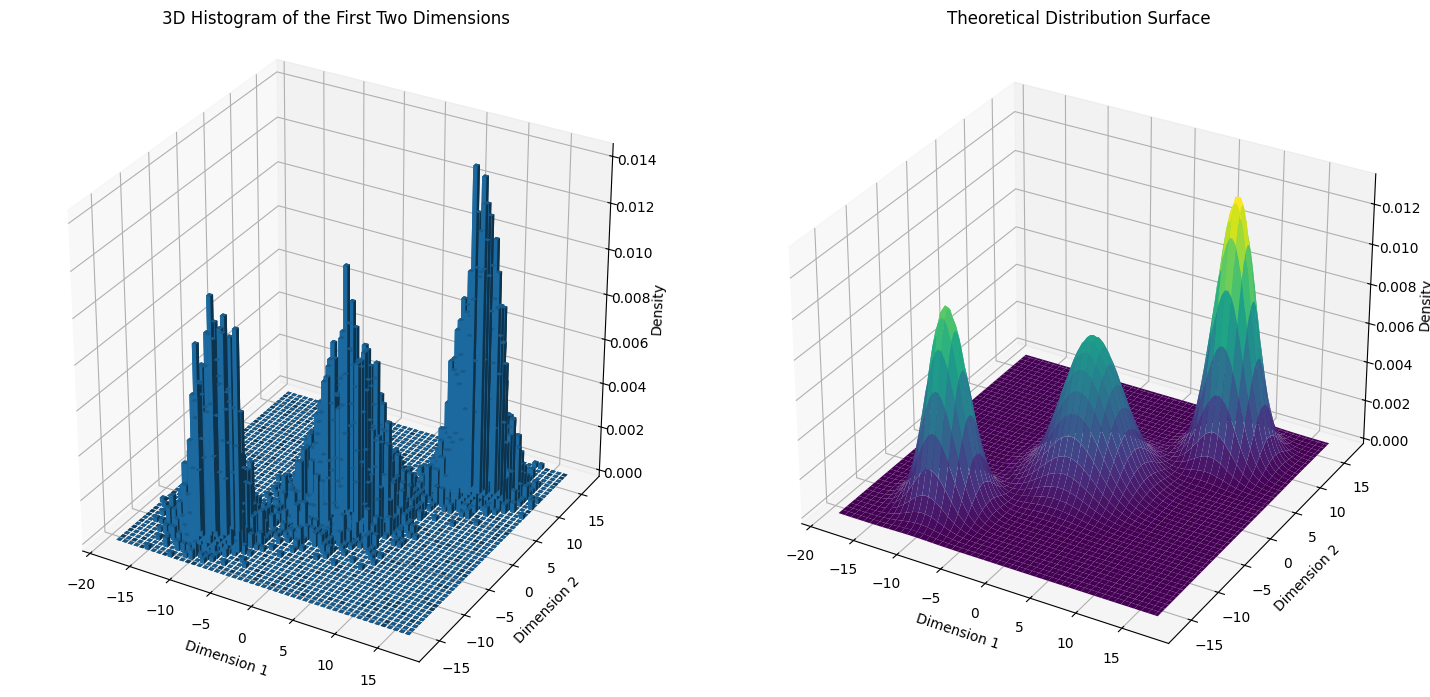

In [15]:
x_data = generated_samples[:, 0].cpu().numpy()  # First dimension
y_data = generated_samples[:, 1].cpu().numpy()  # Second dimension

fig, ax = plt.subplots(1, 2, figsize=(15, 7), subplot_kw={'projection': '3d'})

ax[0].set_box_aspect([1, 1, 1])  
hist, xedges, yedges = np.histogram2d(x_data, y_data, bins=50, density=True)

xpos, ypos = np.meshgrid(xedges[:-1] + 0.1, yedges[:-1] + 0.1, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)

dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax[0].bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')
ax[0].set_zlabel('Density')
ax[0].set_title('3D Histogram of the First Two Dimensions')

x_vals = np.linspace(np.min(x_data), np.max(x_data), 100)
y_vals = np.linspace(np.min(y_data), np.max(y_data), 100)
X, Y = np.meshgrid(x_vals, y_vals)

Z = np.zeros_like(X)
for i in range(3):  
    mean_x, mean_y = means[i, 0], means[i, 1] 
    std = stds[i]
    weight = weights[i]
    Z += weight * (1 / (2 * np.pi * std**2)) * np.exp(-0.5 * ((X - mean_x)**2 + (Y - mean_y)**2) / std**2)

ax[1].plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')
ax[1].set_zlabel('Density')
ax[1].set_title('Theoretical Distribution Surface')

plt.tight_layout()
plt.show()

In [16]:
class NoiseEstimator(nn.Module):
    
    def __init__(self, time_dim=4,dim = 20,  x_emb_dim=5, hidden_dim=64, timesteps=1000, device = 'cpu'):
        super().__init__()
        self.device = device

        self.time_embedding = nn.Embedding(timesteps, time_dim).to(device)
        self.time_dim = time_dim
        self.net_x = nn.Linear(dim, x_emb_dim).to(device)
        self.net = nn.Sequential(
            nn.Linear(x_emb_dim + time_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        ).to(device)
    
    def forward(self, x, t):
        x = x.to(self.device)
        t = t.to(self.device)

        x_emb = self.net_x(x)
        t_emb = self.time_embedding(t)
        x_t = torch.cat([x_emb, t_emb], dim=-1)
        
        return self.net(x_t)

NetNoise = NoiseEstimator(time_dim=20, dim = dim, x_emb_dim=20, hidden_dim=200, timesteps=timesteps, device=device)

In [17]:
x_0_mean =  x_0.mean(dim=0)
x_0_std = x_0_std = x_0.std(axis=0)
x_0_training = (x_0 - x_0_mean) / x_0_std


train_loader = utils.data.DataLoader(x_0_training, batch_size=32)

def train(model, dataloader, timesteps, alpha_bar, noising, epochs=500, lr=1e-4, device='cuda'):
    
    """
    This function simply implements the training of the noiser model
    
    Training using the instructions given by arXiv:2006.11239v2
    
    """
    
    
    
    model = model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            batch = batch.to(device)
            noise = torch.randn_like(batch)
            t = torch.randint(1, timesteps, size=(batch.shape[0],), device=batch.device)
            noised = noising(t_index=t, x_0=batch, alpha_bar=alpha_bar, noise=noise)
            pred_noise = model(noised, t)
            loss = nn.functional.mse_loss(pred_noise, noise)
        
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()*batch.shape[0]
            
        print(f"Epoch {epoch+1}: Loss = {total_loss / len(dataloader.dataset)}")
    
    model.eval()
    

In [18]:
train(model = NetNoise, dataloader = train_loader, epochs = 50, timesteps = timesteps, alpha_bar = alpha_bar, noising =  noising, lr = 1e-4, device = device )

Epoch 1: Loss = 0.2911424436235428
Epoch 2: Loss = 0.22938484731435776
Epoch 3: Loss = 0.22174199123620986
Epoch 4: Loss = 0.21927411171913147
Epoch 5: Loss = 0.2159088625240326
Epoch 6: Loss = 0.21456627473115922
Epoch 7: Loss = 0.21096695716381073
Epoch 8: Loss = 0.20787981601953506
Epoch 9: Loss = 0.20364693254709243
Epoch 10: Loss = 0.20136285657167435
Epoch 11: Loss = 0.19840093091487884
Epoch 12: Loss = 0.1944166747546196
Epoch 13: Loss = 0.1926227876806259
Epoch 14: Loss = 0.19100053867697717
Epoch 15: Loss = 0.18768288097143174
Epoch 16: Loss = 0.18589476589679718
Epoch 17: Loss = 0.1822303914141655
Epoch 18: Loss = 0.18139361891031267
Epoch 19: Loss = 0.17905883241653442
Epoch 20: Loss = 0.1782429296696186
Epoch 21: Loss = 0.17726820870637894
Epoch 22: Loss = 0.17594517393231393
Epoch 23: Loss = 0.17280845650434495
Epoch 24: Loss = 0.17417351915597915
Epoch 25: Loss = 0.17035157171845436
Epoch 26: Loss = 0.17013860369861125
Epoch 27: Loss = 0.1691379384481907
Epoch 28: Loss = 

In [21]:
generated_samples_noise = generate_with_noiser_multi(size =  50000,  dim = dim, noiser = NetNoise, mean = x_0_mean, std = x_0_std, normalized = True , beta = beta, alpha_bar = alpha_bar, alpha = alpha, timesteps = timesteps)
print(generated_samples_noise.device)

cpu


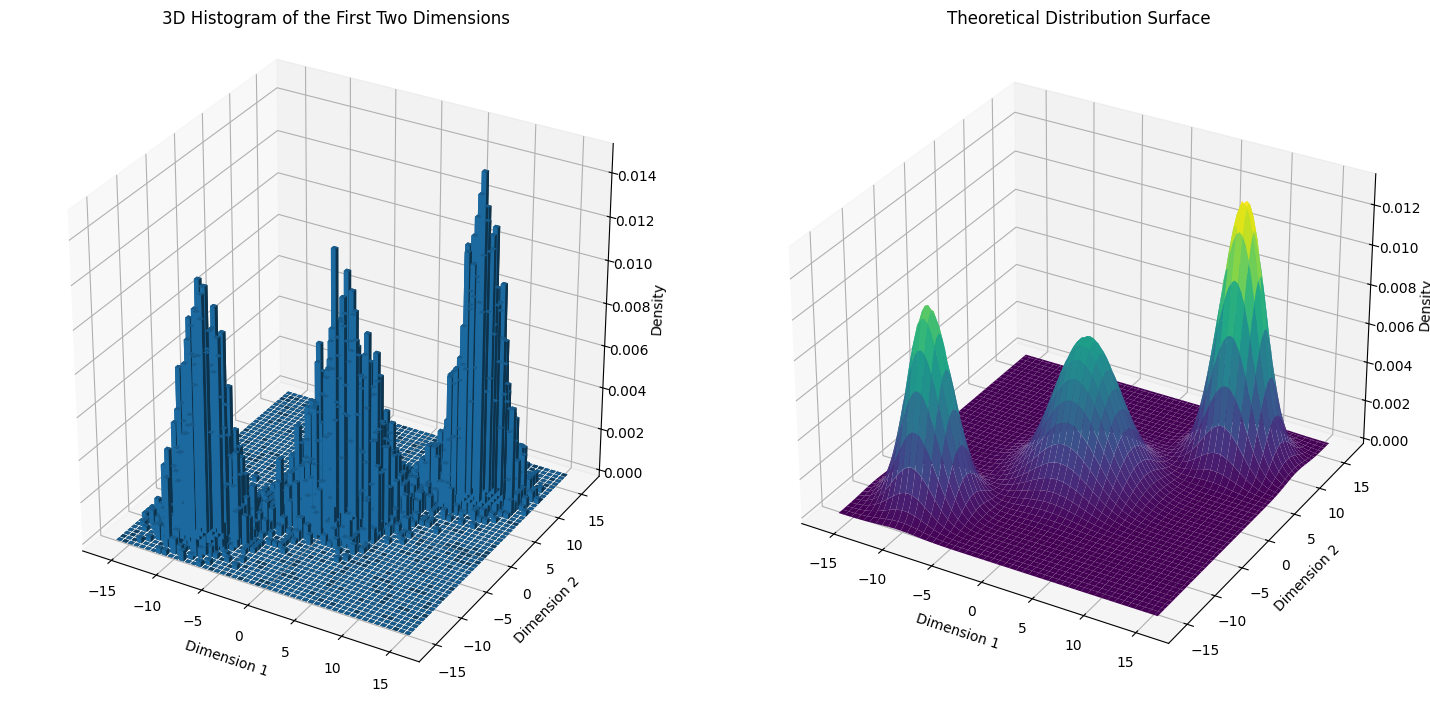

In [20]:
x_data = generated_samples_noise[:, 0].cpu().numpy()  # First dimension
y_data = generated_samples_noise[:, 1].cpu().numpy()  # Second dimension


fig, ax = plt.subplots(1, 2, figsize=(15, 7), subplot_kw={'projection': '3d'})

ax[0].set_box_aspect([1, 1, 1])  
hist, xedges, yedges = np.histogram2d(x_data, y_data, bins=50, density=True)

xpos, ypos = np.meshgrid(xedges[:-1] + 0.1, yedges[:-1] + 0.1, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)

dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax[0].bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')
ax[0].set_zlabel('Density')
ax[0].set_title('3D Histogram of the First Two Dimensions')

x_vals = np.linspace(np.min(x_data), np.max(x_data), 100)
y_vals = np.linspace(np.min(y_data), np.max(y_data), 100)

X, Y = np.meshgrid(x_vals, y_vals)

Z = np.zeros_like(X)
for i in range(3):  
    mean_x, mean_y = means[i, 0], means[i, 1] 
    std = stds[i]
    weight = weights[i]
    Z += weight * (1 / (2 * np.pi * std**2)) * np.exp(-0.5 * ((X - mean_x)**2 + (Y - mean_y)**2) / std**2)

ax[1].plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')
ax[1].set_zlabel('Density')
ax[1].set_title('Theoretical Distribution Surface')

plt.tight_layout()
plt.show()